<a href="https://colab.research.google.com/github/Miyazaki-Kohei/adhoc_analysis/blob/main/Web_optimization_chap3_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-916-8.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『ウェブ最適化ではじめる機械学習』（飯塚 修平　著）](https://www.oreilly.co.jp/books/9784873119168/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

# 3章: 組合せのあるテスト: 要素に分解して考える

必要なモジュールのインストール

In [32]:
!pip install arviz==0.17.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.9 MB/s eta 0:00:00
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Uninstalling arviz-0.15.1:
      Successfully uninstalled arviz-0.15.1


In [1]:
!pip install -U pymc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.18.6
    Uninstalling pytensor-2.18.6:
      Successfully uninstalled pytensor-2.18.6
  Attempting uninstall: pymc
    Found existing installation: pymc 5.10.4
    Uninstalling pymc-5.10.4:
      Successfully uninstalled pymc-5.10.4


必要なモジュールの読み込み

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymc as pm

plt.style.use('grayscale')
plt.style.use('seaborn-whitegrid')
np.random.seed(0)

<ipython-input-2-427f1aa11929>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## チャーリーのレポート

クリック率 $\theta$ のサンプルの軌跡

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


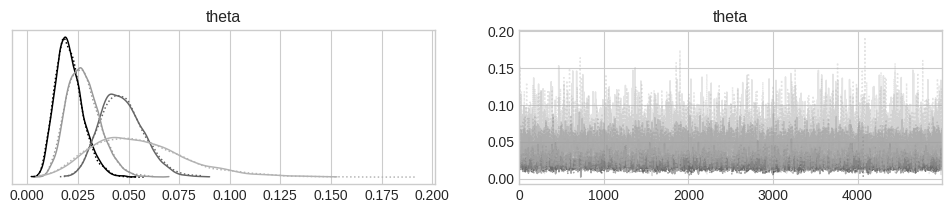

In [3]:
n = [434, 382, 394, 88]
clicks = [8, 17, 10, 4]
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=len(n))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace = pm.sample(5000, chains=2)
  pm.plot_trace(trace, compact=True)

In [4]:
# with model:
#   print(pm.summary(trace, hdi_prob=0.95))

pm.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.021,0.007,0.008,0.034,0.0,0.0,14431.0,7698.0,1.0
theta[1],0.047,0.011,0.027,0.068,0.0,0.0,11499.0,7204.0,1.0
theta[2],0.028,0.008,0.012,0.044,0.0,0.0,15800.0,7992.0,1.0
theta[3],0.056,0.024,0.014,0.103,0.0,0.0,14037.0,7379.0,1.0


確率変数 $\theta$ の事後分布の95% HDIの比較

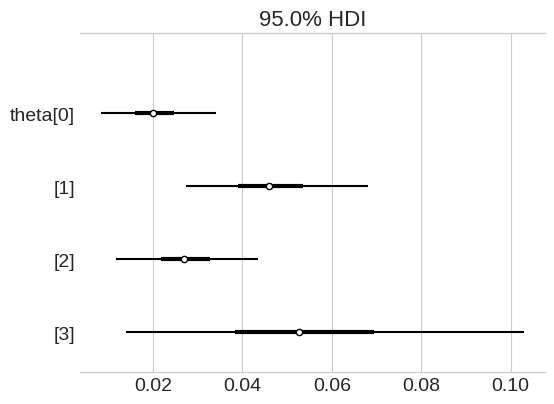

In [5]:
with model:
  pm.plot_forest(trace, combined=True, hdi_prob=0.95)

A案とB案のクリック率の差が正となる割合

In [6]:
print((trace.posterior['theta'][:, :, 1] - trace.posterior['theta'][:, :, 0] > 0).mean())

<xarray.DataArray 'theta' ()>
array(0.9836)


A案とD案のクリック率の差が正となる割合

In [7]:
print((trace.posterior['theta'][:, :, 3] - trace.posterior['theta'][:, :, 0] > 0).mean())

<xarray.DataArray 'theta' ()>
array(0.9487)


## 効果に着目したモデリング

ロジスティック関数

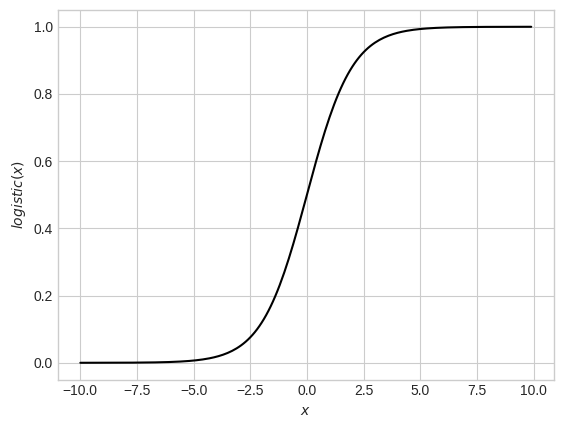

In [8]:
xs = np.arange(-10, 10, 0.1)
plt.plot(xs, 1 / (1 + np.exp(-xs)))
plt.xlabel(r'$x$')
plt.ylabel(r'$logistic(x)$')
plt.show()

さまざまな正規分布の例

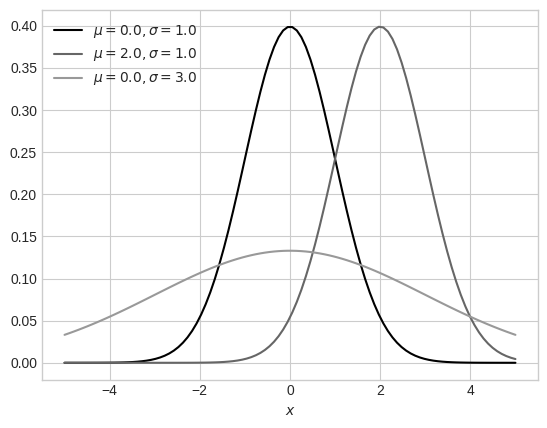

In [9]:
from scipy import stats
x = np.linspace(-5, 5, 100)
params = [(0, 1), (2, 1), (0, 3)]
for mu, sigma in params:
  plt.plot(x, stats.norm.pdf(x, mu, sigma),
      label=r'$\mu=%.1f, \sigma=%.1f$' % (mu, sigma))
plt.legend()
plt.xlabel(r'$x$')
plt.show()

## 統計モデルを書き直す

In [10]:
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

with pm.Model() as model_comb:
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  comb = alpha + beta[0] * img + beta[1] * btn
  theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_comb = pm.sample(5000, chains=2)

Output()

Output()

書き直した統計モデルについて得られたサンプルの軌跡

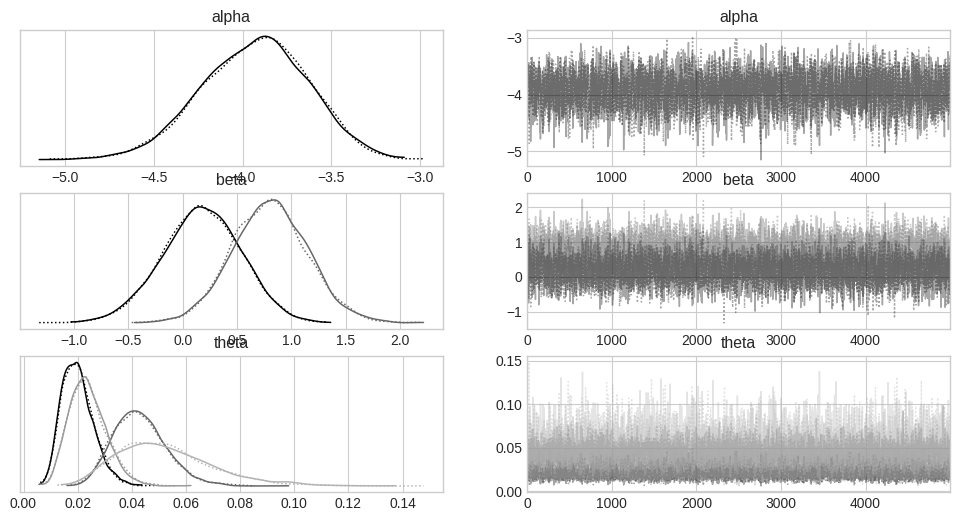

In [11]:
with model_comb:
  pm.plot_trace(trace_comb)

$\beta$ の事後分布の可視化

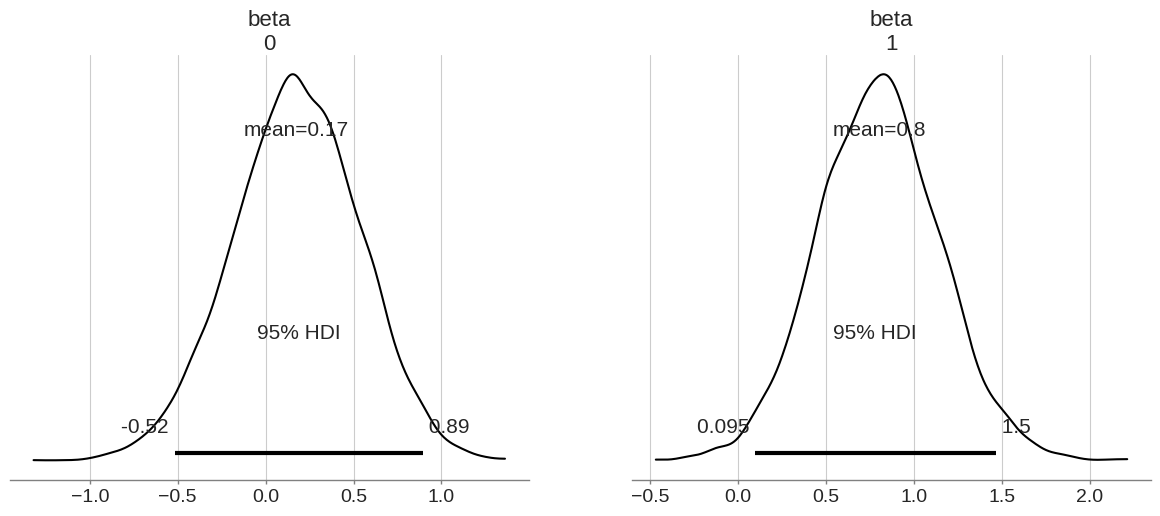

In [12]:
with model_comb:
  pm.plot_posterior(trace_comb, var_names=['beta'], hdi_prob=0.95)

In [14]:
print((trace_comb.posterior['beta'][:, :, 1] > 0).mean())

<xarray.DataArray 'beta' ()>
array(0.9901)
Coordinates:
    beta_dim_0  int64 1


   クリック率 $\theta$ がデザイン案ごとに独立したモデル（Individual）と、
   施策効果によって接続されたモデル（Combined）それぞれについて得られた事後分布の95% HDIの比較

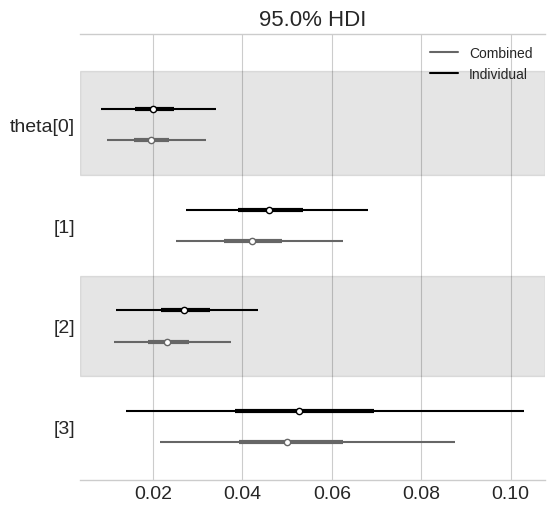

In [15]:
with pm.Model():
  pm.plot_forest([trace, trace_comb], var_names=['theta'],
                 hdi_prob=0.95, combined=True,
                 model_names=['Individual', 'Combined'])

In [17]:
print((trace_comb.posterior['theta'][:, :, 1] - trace_comb.posterior['theta'][:, :, 0] > 0).mean())
print((trace_comb.posterior['theta'][:, :, 3] - trace_comb.posterior['theta'][:, :, 0] > 0).mean())

<xarray.DataArray 'theta' ()>
array(0.9901)
<xarray.DataArray 'theta' ()>
array(0.9558)


## 完成したレポート、間違ったモデル

完成したレポートに、同じ統計モデルをあてはめたときのサンプルの軌跡

Output()

Output()

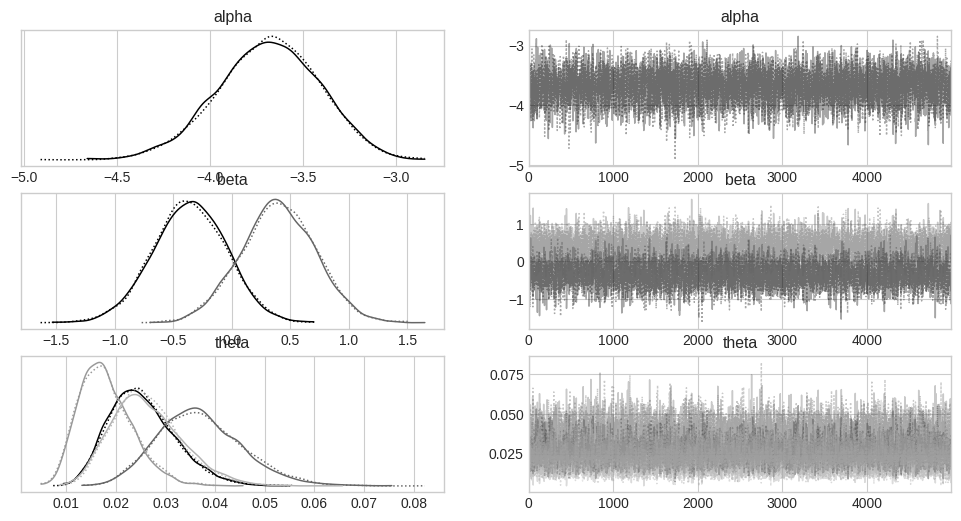

In [19]:
n = [434, 382, 394, 412]
clicks = [8, 17, 10, 8]
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

with pm.Model() as model_comb2:
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  comb = alpha + beta[0] * img + beta[1] * btn
  theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_comb2 = pm.sample(5000, chains=2)
  pm.plot_trace(trace_comb2, compact=True)

In [20]:
print((trace_comb2.posterior['beta'][:, :, 1] > 0).mean())

<xarray.DataArray 'beta' ()>
array(0.888)
Coordinates:
    beta_dim_0  int64 1


交互作用項を追加した統計モデルから得られたサンプルの軌跡

Output()

Output()

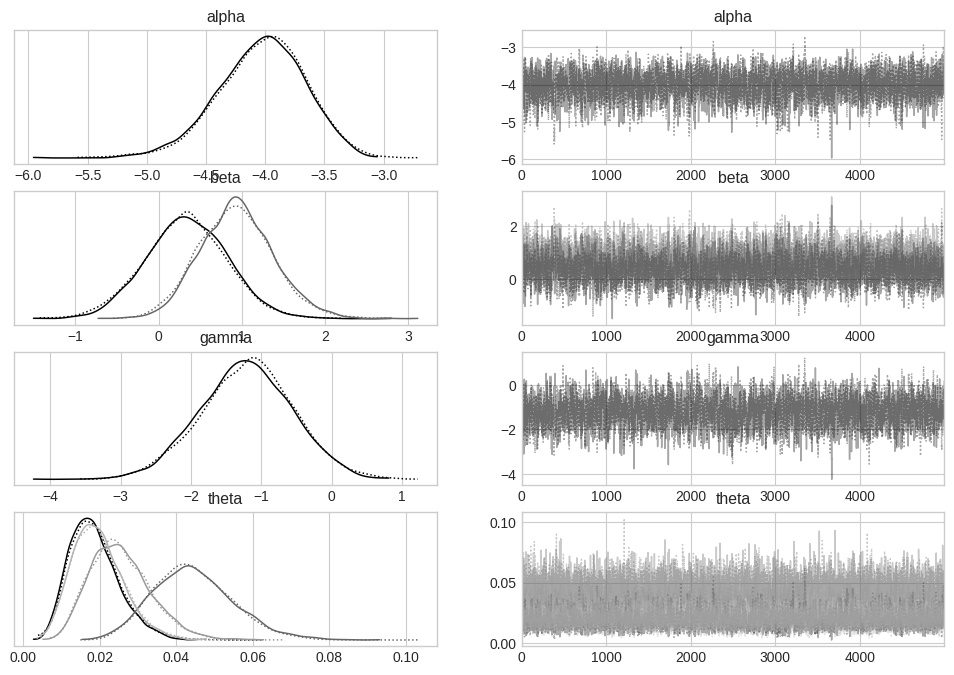

In [21]:
with pm.Model() as model_int:
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  gamma = pm.Normal('gamma', mu=0, sigma=10)
  comb = alpha + beta[0] * img + beta[1] * btn + gamma * img * btn
  theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_int = pm.sample(5000, chains=2)
  pm.plot_trace(trace_int, compact=True)

In [22]:
print((trace_int.posterior['gamma'] < 0).mean())

<xarray.DataArray 'gamma' ()>
array(0.9677)


In [23]:
print((trace_int.posterior['beta'][:, :, 0] > 0).mean())
print((trace_int.posterior['beta'][:, :, 1] > 0).mean())

<xarray.DataArray 'beta' ()>
array(0.7527)
Coordinates:
    beta_dim_0  int64 0
<xarray.DataArray 'beta' ()>
array(0.9865)
Coordinates:
    beta_dim_0  int64 1


## モデル選択

主効果のみのモデルCombinedの可視化

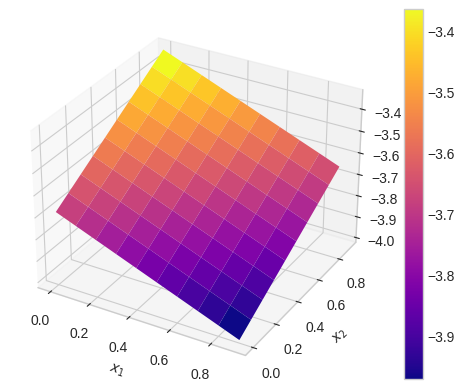

In [26]:
from mpl_toolkits.mplot3d import Axes3D

x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
logit_theta = (trace_comb2.posterior['alpha'].values.mean() +
      trace_comb2.posterior['beta'][:, :, 0].values.mean() * X1 +
      trace_comb2.posterior['beta'][:, :, 1].values.mean() * X2)
surf = ax.plot_surface(X1, X2, logit_theta, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()

交互作用を含んだモデルInteractionの可視化

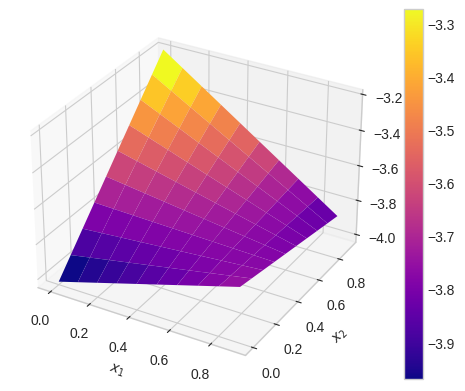

In [29]:
x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Y = (trace_int.posterior['alpha'].values.mean() +
      trace_int.posterior['beta'][:, :, 0].values.mean() * X1 +
      trace_int.posterior['beta'][:, :, 1].values.mean() * X2 +
      trace_int.posterior['gamma'].values.mean() * X1 * X2)
surf = ax.plot_surface(X1, X2, Y, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()

In [31]:
trace_comb2

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [30]:
waic_comb2 = pm.waic(trace_comb2, model_comb2)
waic_int = pm.waic(trace_int, model_int)
print(waic_comb2.p_waic)
print(waic_int.p_waic)

TypeError: log likelihood not found in inference data object